# Restaurant Revenue Prediction

In [1]:
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from collections import Counter

## 1.   Analysis of data

In [2]:
# load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# columns in train dataset
train.columns

Index(['Id', 'Open Date', 'City', 'City Group', 'Type', 'P1', 'P2', 'P3', 'P4',
       'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15',
       'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25',
       'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35',
       'P36', 'P37', 'revenue'],
      dtype='object')

In [4]:
# shapes of datasets
print("Train :",train.shape)
print("Test:",test.shape)

Train : (137, 43)
Test: (100000, 42)


In [5]:
train['Open Date'] = pd.to_datetime(train['Open Date'])
test['Open Date'] = pd.to_datetime(test['Open Date'])

In [6]:
# get columns with NULLs  (if exist)
train.columns[train.isna().any()].tolist()

[]

In [7]:
test.columns[test.isna().any()].tolist()

[]

Жодного значення NULL не знайшлося :)

In [8]:
#Seperate categorical from numerical variables
numerical_features = train.select_dtypes([np.number]).columns.tolist()
categorical_features = train.select_dtypes(exclude = [np.number,np.datetime64]).columns.tolist()

In [9]:
categorical_features

['City', 'City Group', 'Type']

In [10]:
train[categorical_features].head()

,City,City Group,Type
0,İstanbul,Big Cities,IL
1,Ankara,Big Cities,FC
2,Diyarbakır,Other,IL
3,Tokat,Other,IL
4,Gaziantep,Other,IL


In [11]:
train[numerical_features].head()

,Id,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,4,5.0,4.0,4.0,2,2,5,4,5,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,4,5.0,4.0,4.0,1,2,5,5,5,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,2,4.0,2.0,5.0,2,3,5,5,5,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,6,4.5,6.0,6.0,4,4,10,8,10,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,3,4.0,3.0,4.0,2,2,5,5,5,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [12]:
train[numerical_features].describe()

,Id,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,...,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,1.370000e+02
mean,68.000000,4.014599,4.408759,4.317518,4.372263,2.007299,3.357664,5.423358,5.153285,5.445255,...,3.135036,2.729927,1.941606,2.525547,1.138686,2.489051,2.029197,2.211679,1.116788,4.453533e+06
std,39.692569,2.910391,1.514900,1.032337,1.016462,1.209620,2.134235,2.296809,1.858567,1.834793,...,1.680887,5.536647,3.512093,5.230117,1.698540,5.165093,3.436272,4.168211,1.790768,2.576072e+06
min,0.000000,1.000000,1.000000,0.000000,3.000000,1.000000,1.000000,1.000000,1.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.149870e+06
25%,34.000000,2.000000,4.000000,4.000000,4.000000,1.000000,2.000000,5.000000,4.000000,4.000000,...,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.999068e+06
50%,68.000000,3.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,5.000000,5.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.939804e+06
75%,102.000000,4.000000,5.000000,5.000000,5.000000,2.000000,4.000000,5.000000,5.000000,5.000000,...,3.000000,4.000000,3.000000,3.000000,2.000000,3.000000,4.000000,3.000000,2.000000,5.166635e+06
max,136.000000,12.000000,7.500000,7.500000,7.500000,8.000000,10.000000,10.000000,10.000000,10.000000,...,7.500000,25.000000,15.000000,25.000000,6.000000,24.000000,15.000000,20.000000,8.000000,1.969694e+07


count    1.370000e+02
mean     4.453533e+06
std      2.576072e+06
min      1.149870e+06
25%      2.999068e+06
50%      3.939804e+06
75%      5.166635e+06
max      1.969694e+07
Name: revenue, dtype: float64


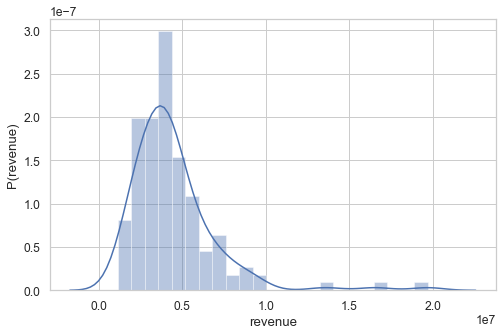

In [13]:
print(train['revenue'].describe())
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    train['revenue'], norm_hist=False, kde=True
).set(xlabel='revenue', ylabel='P(revenue)');

На графіку видно, що деякі (поодинокі) значення суттєво відрізняються від решти, що може негативно повпливати на процес навчання. 

In [14]:
train[train['revenue'] > 10000000 ]

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
16,16,2000-01-07,İstanbul,Big Cities,FC,3,5.0,4.0,4.0,2,...,2.0,0,0,0,0,0,0,0,0,19696939.0
75,75,2005-10-15,İstanbul,Big Cities,FC,5,5.0,4.0,5.0,1,...,0.0,0,0,0,0,0,0,0,0,16549064.0
99,99,1999-12-18,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,1.0,5,5,4,2,5,5,5,3,13575224.0


Всього 3 рядки. Ми їх відкидаємо.

In [15]:
train = train[train['revenue'] < 10000000 ]
train.reset_index(drop=True).head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,1999-07-17,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,2008-02-14,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,2013-03-09,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,2012-02-02,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,2009-05-09,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


Оскільки значення числових характеристик є цілочисельні, то покажемо на графіках кожної частоту появи цих значень.

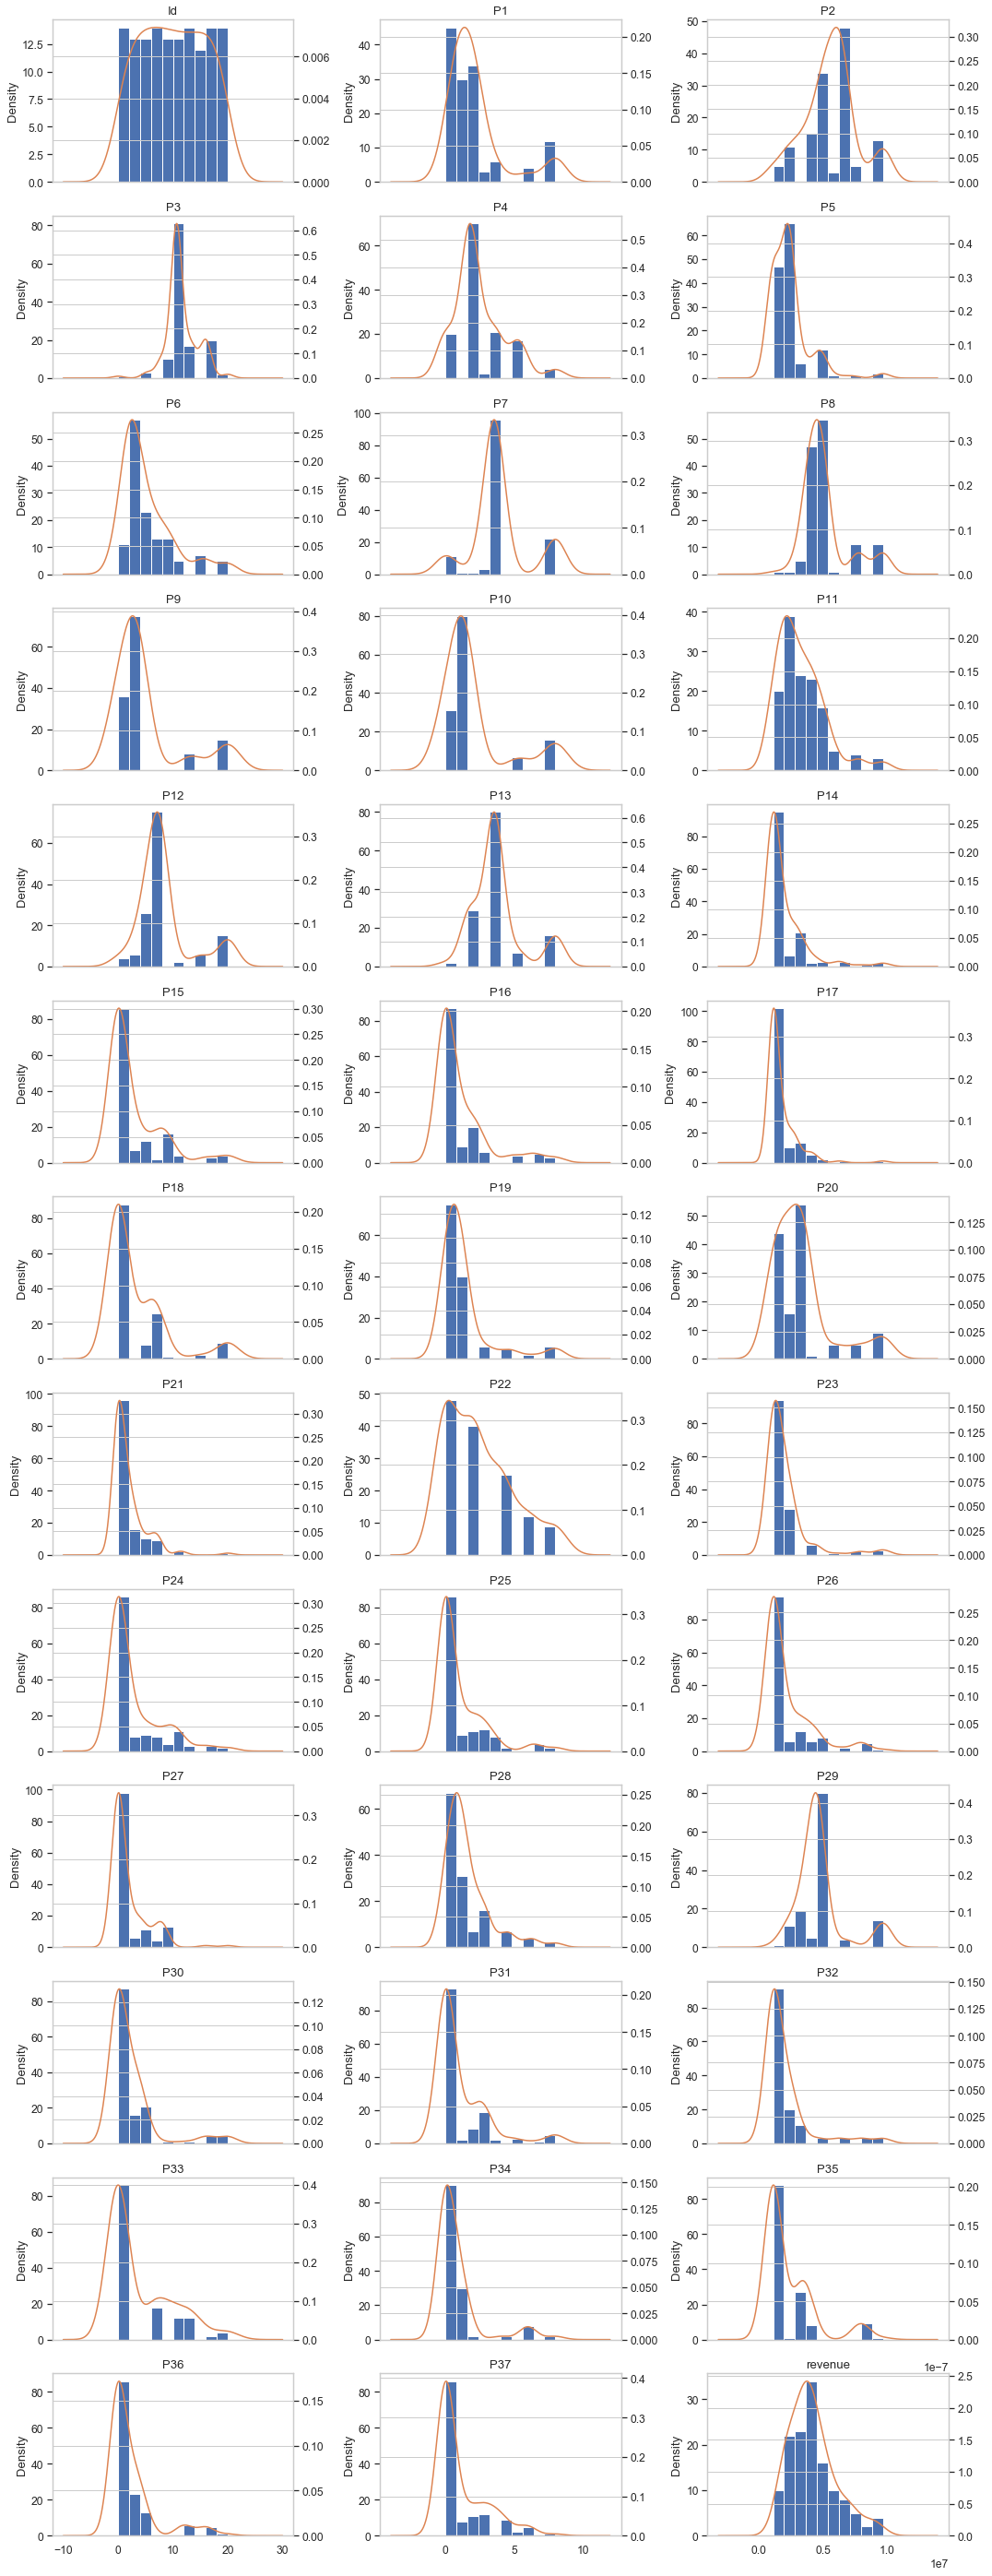

In [16]:
k = len(train[numerical_features].columns)
n = 3
m = (k - 1) // n + 1 
fig, axes = plt.subplots(m, n, figsize=(n * 5, m * 3))
for i, (name, col) in enumerate(train[numerical_features].iteritems()):
    r, c = i // n, i % n
    ax = axes[r, c]
    col.hist(ax=ax)
    ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name)
    ax2.set_ylim(0)

fig.tight_layout()

Залежність між числовими характеристиками і прибутком (revenue):

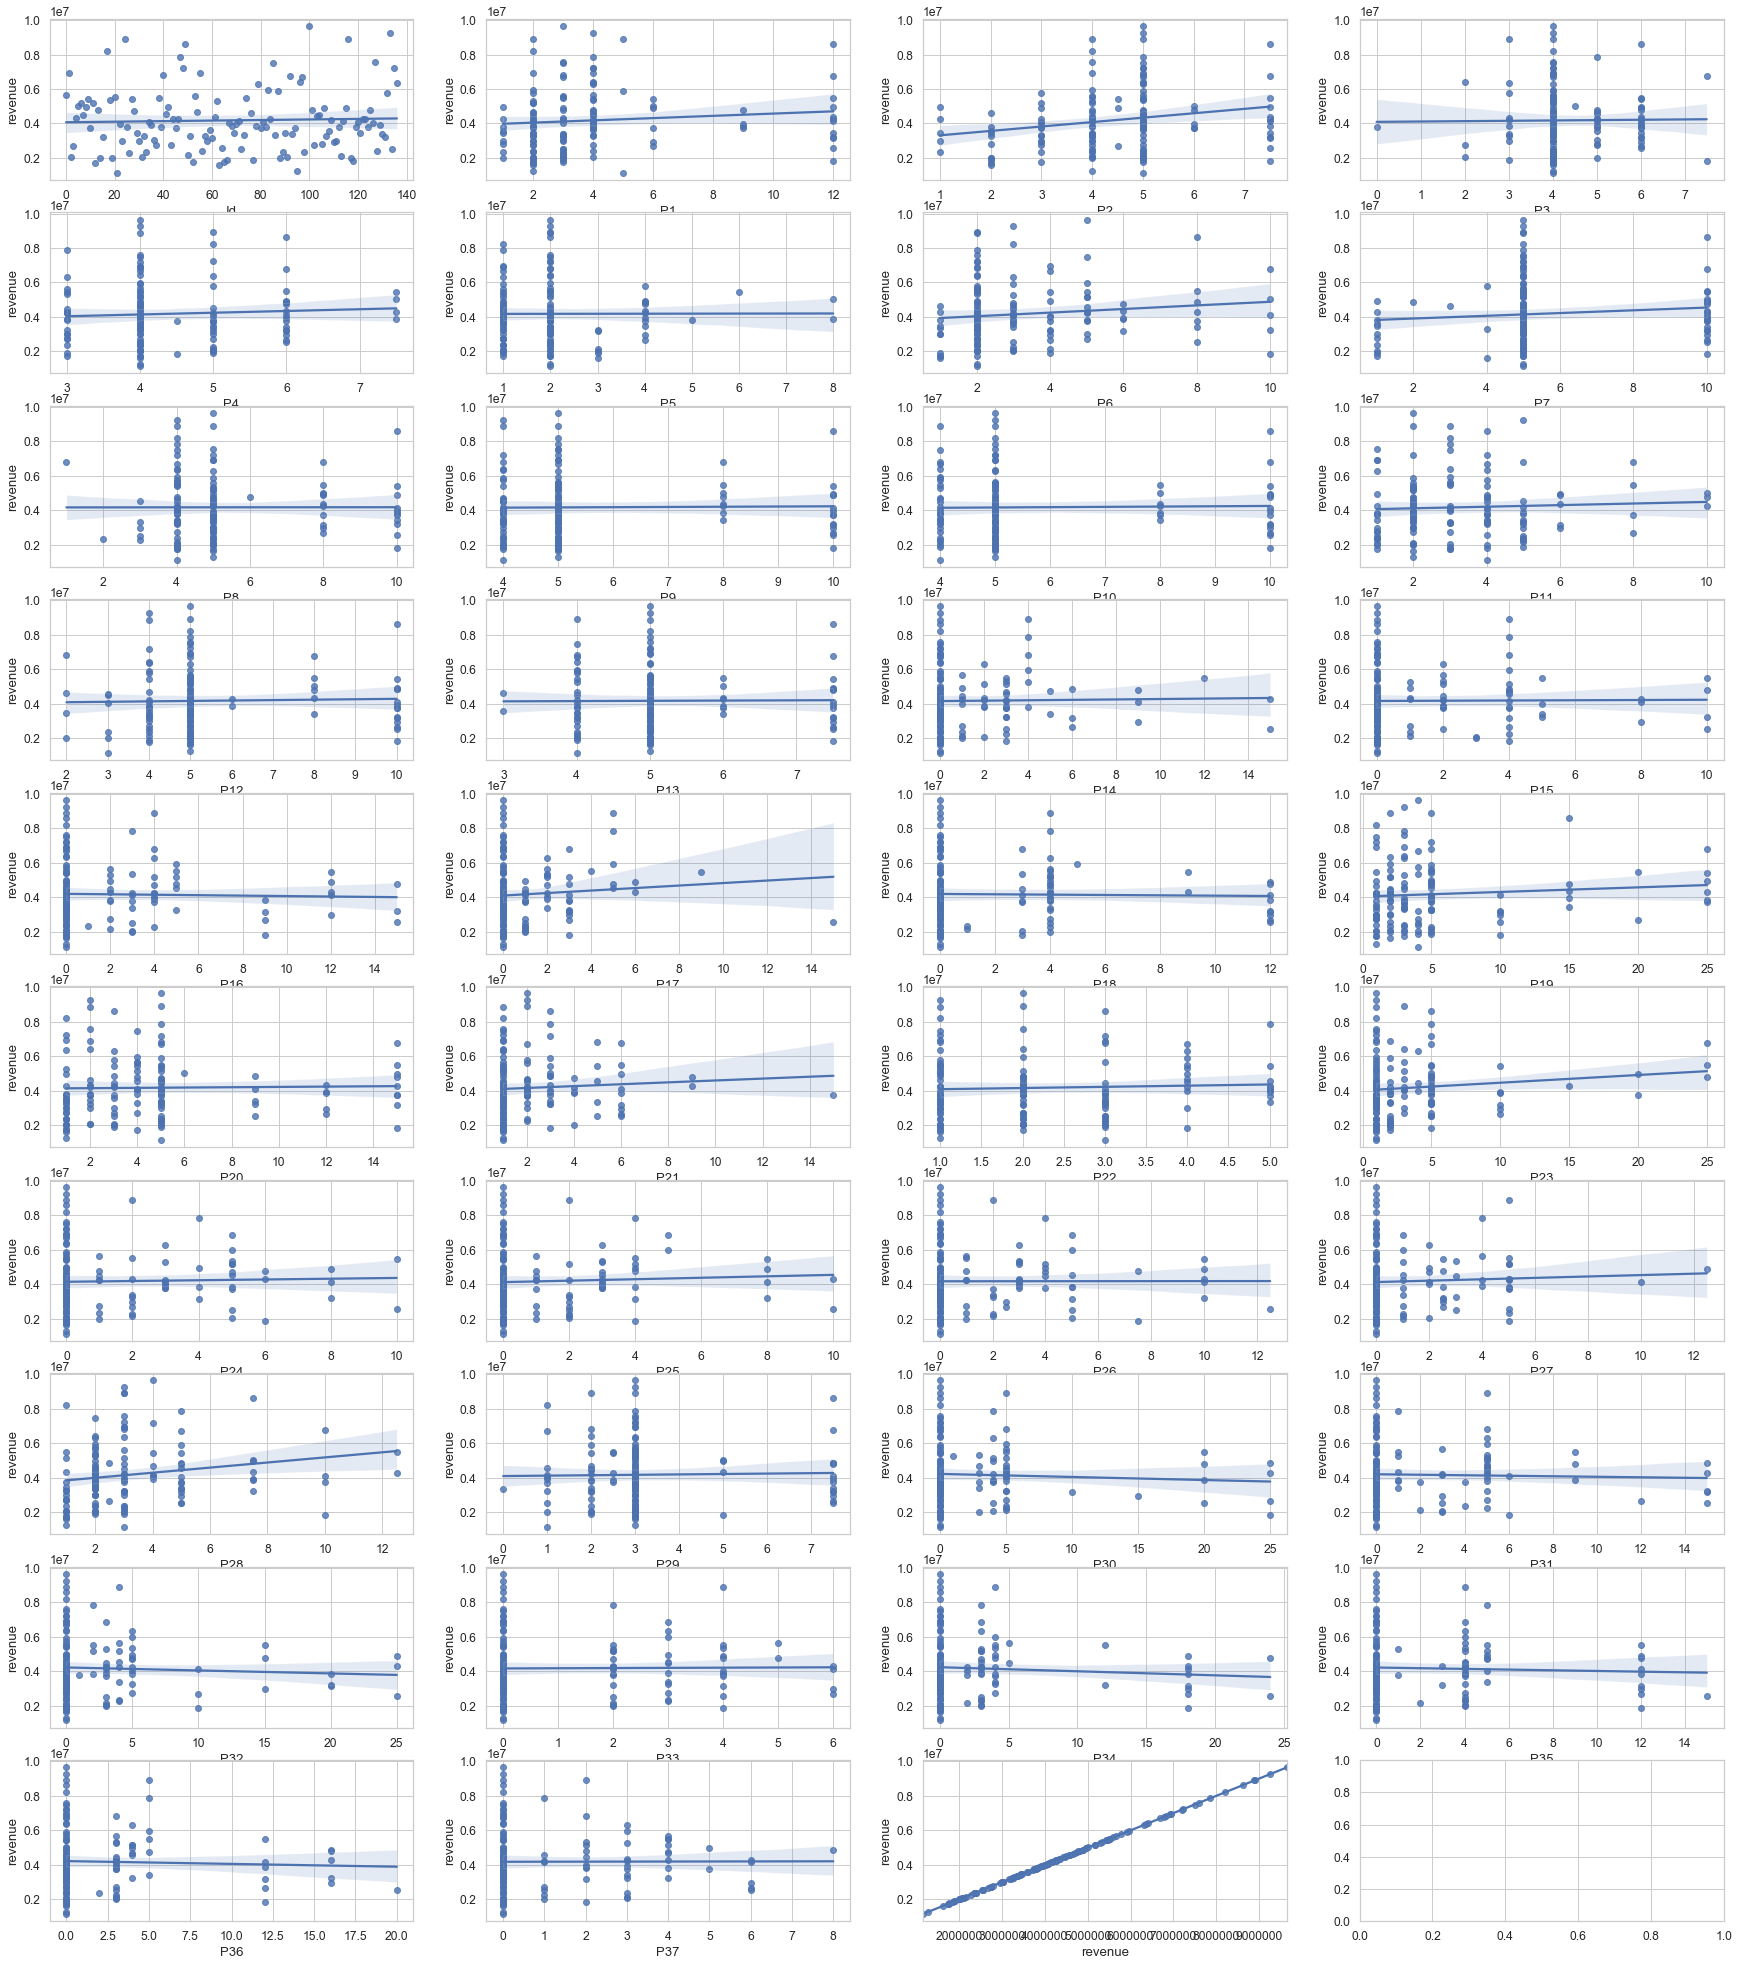

In [17]:
fig, ax = plt.subplots(10, 4, figsize=(30, 35))
for variable, subplot in zip(numerical_features, ax.flatten()):
    sns.regplot(x=train[variable], y=train['revenue'], ax=subplot)

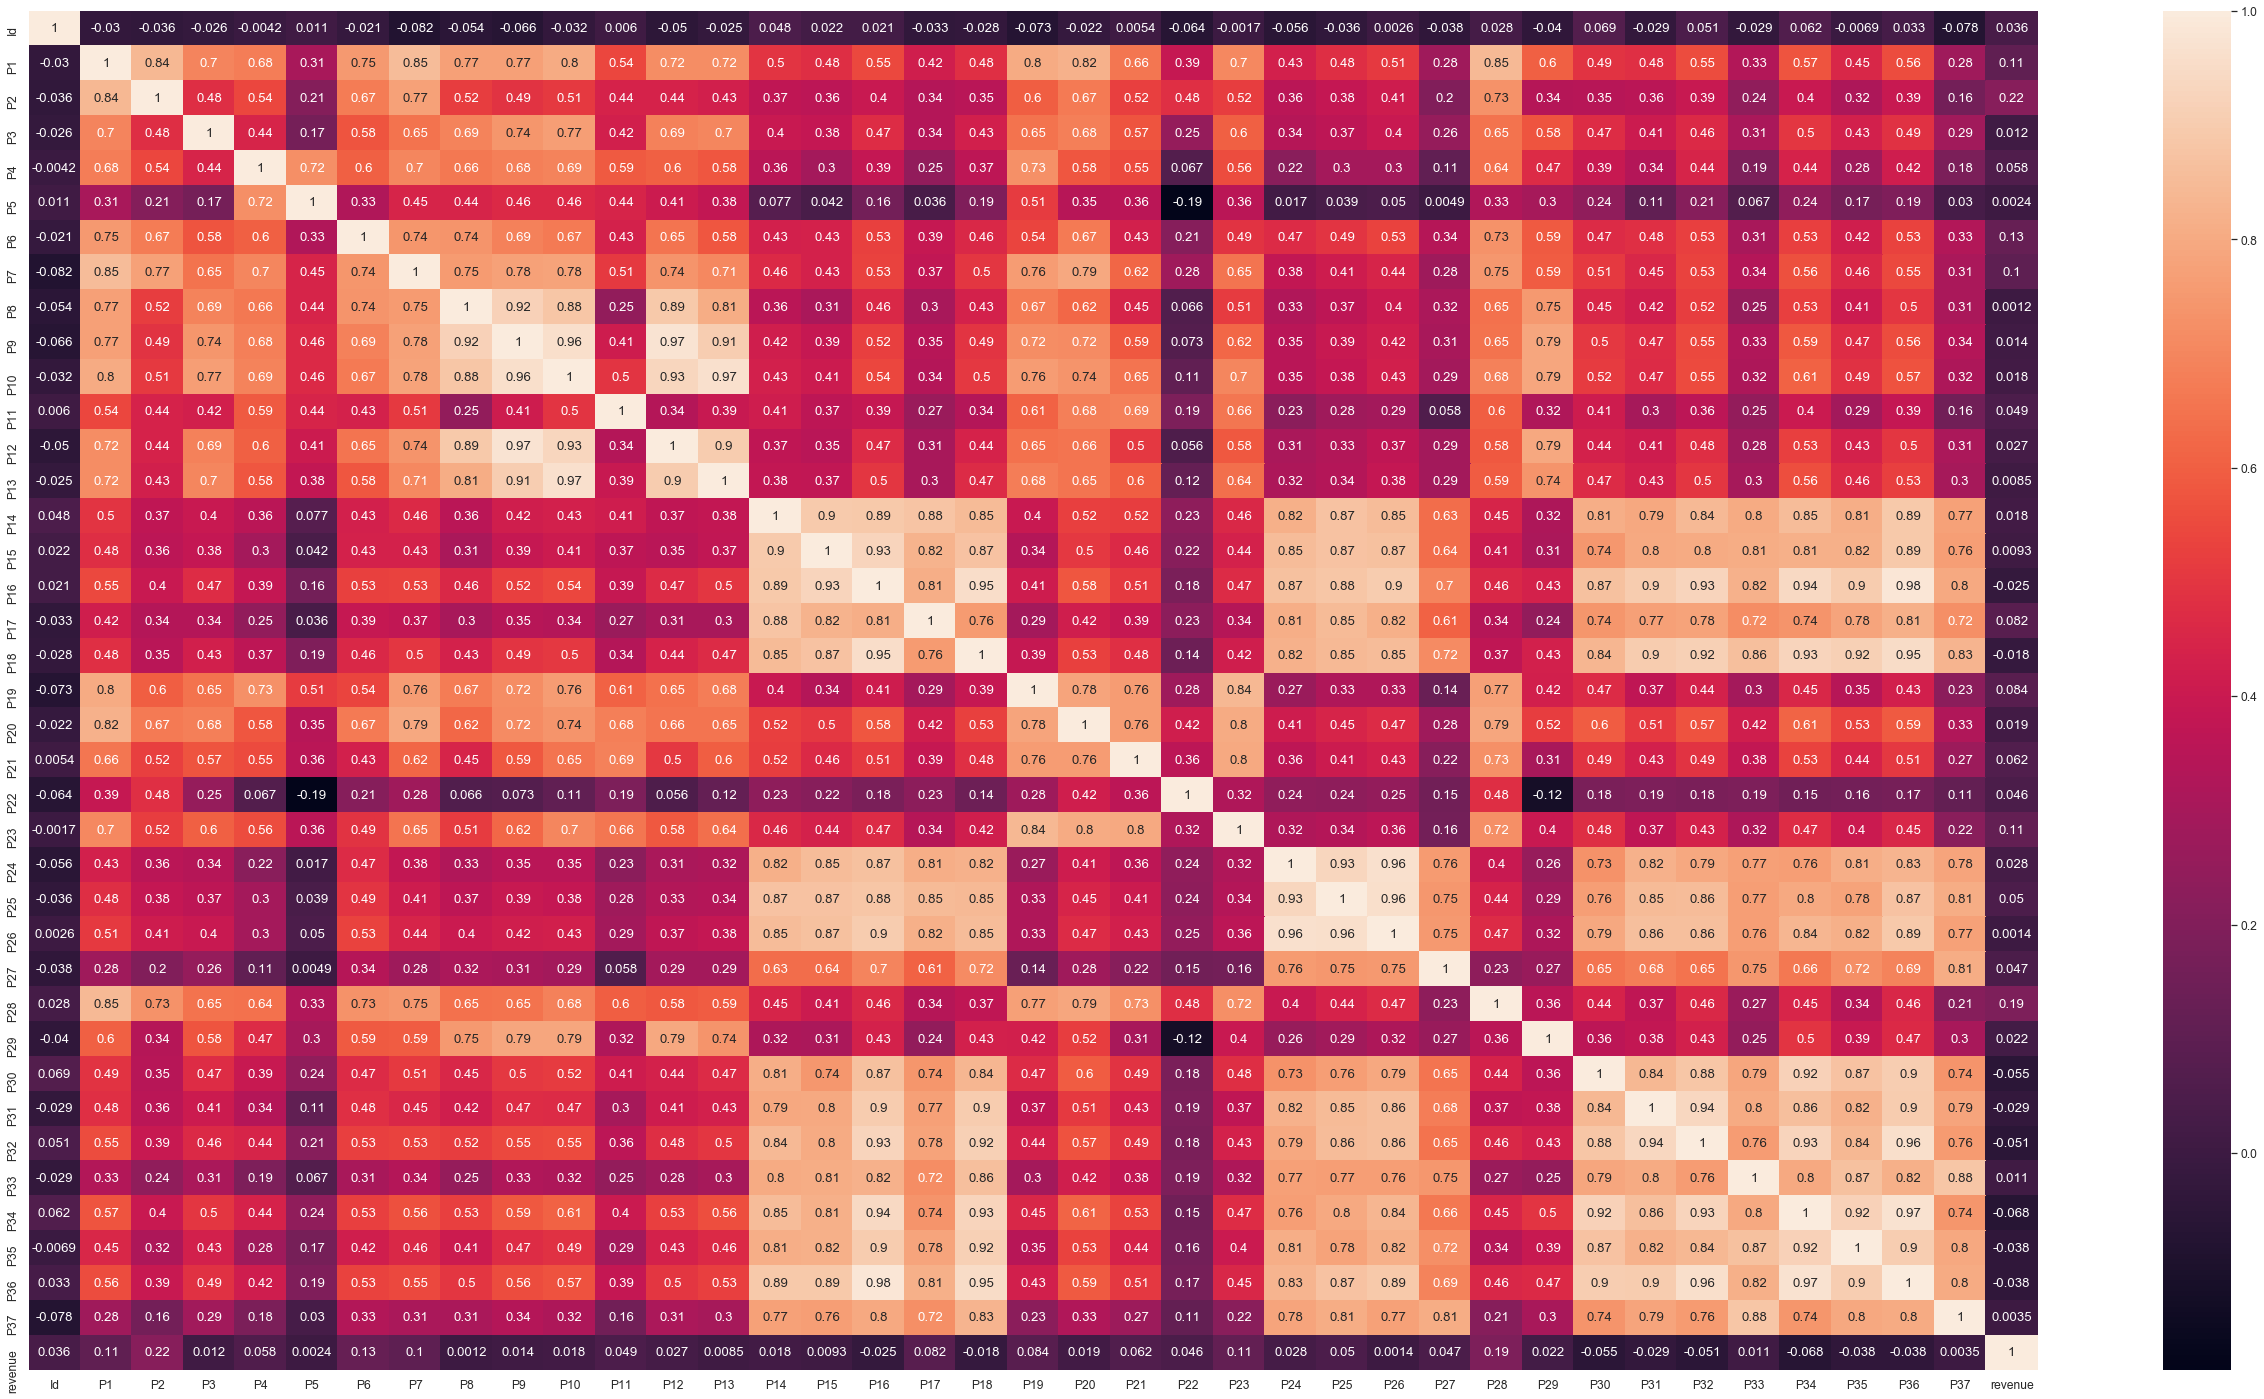

In [18]:
plt.figure(figsize=(45,25))
sns.heatmap(train.corr(),annot=True)

Бачимо, що очевидних відхилень між числовими характеристиками немає. Окремо покажемо кореляцію характеристик з прибутком:

In [19]:
# Correlations of features with target variable
correlations = train.corr()
correlations['revenue']

Id         0.035886
P1         0.106975
P2         0.217491
P3         0.011755
P4         0.057928
P5         0.002373
P6         0.125315
P7         0.102491
P8         0.001171
P9         0.013561
P10        0.018277
P11        0.049328
P12        0.026608
P13        0.008513
P14        0.018282
P15        0.009322
P16       -0.025185
P17        0.081541
P18       -0.018292
P19        0.083804
P20        0.018973
P21        0.061999
P22        0.046387
P23        0.114357
P24        0.028426
P25        0.049852
P26        0.001369
P27        0.046918
P28        0.190908
P29        0.022115
P30       -0.055073
P31       -0.028761
P32       -0.050743
P33        0.010659
P34       -0.068246
P35       -0.038330
P36       -0.038126
P37        0.003478
revenue    1.000000
Name: revenue, dtype: float64

In [20]:
# Select more relevant features (where corr >= 0.1)
cor_target = abs(correlations['revenue'])

relevant_features = cor_target[cor_target >= 0.1]
relevant_features

P1         0.106975
P2         0.217491
P6         0.125315
P7         0.102491
P23        0.114357
P28        0.190908
revenue    1.000000
Name: revenue, dtype: float64

Проаналізуємо решту характеристик відносно загального прибутку (total_revenue):

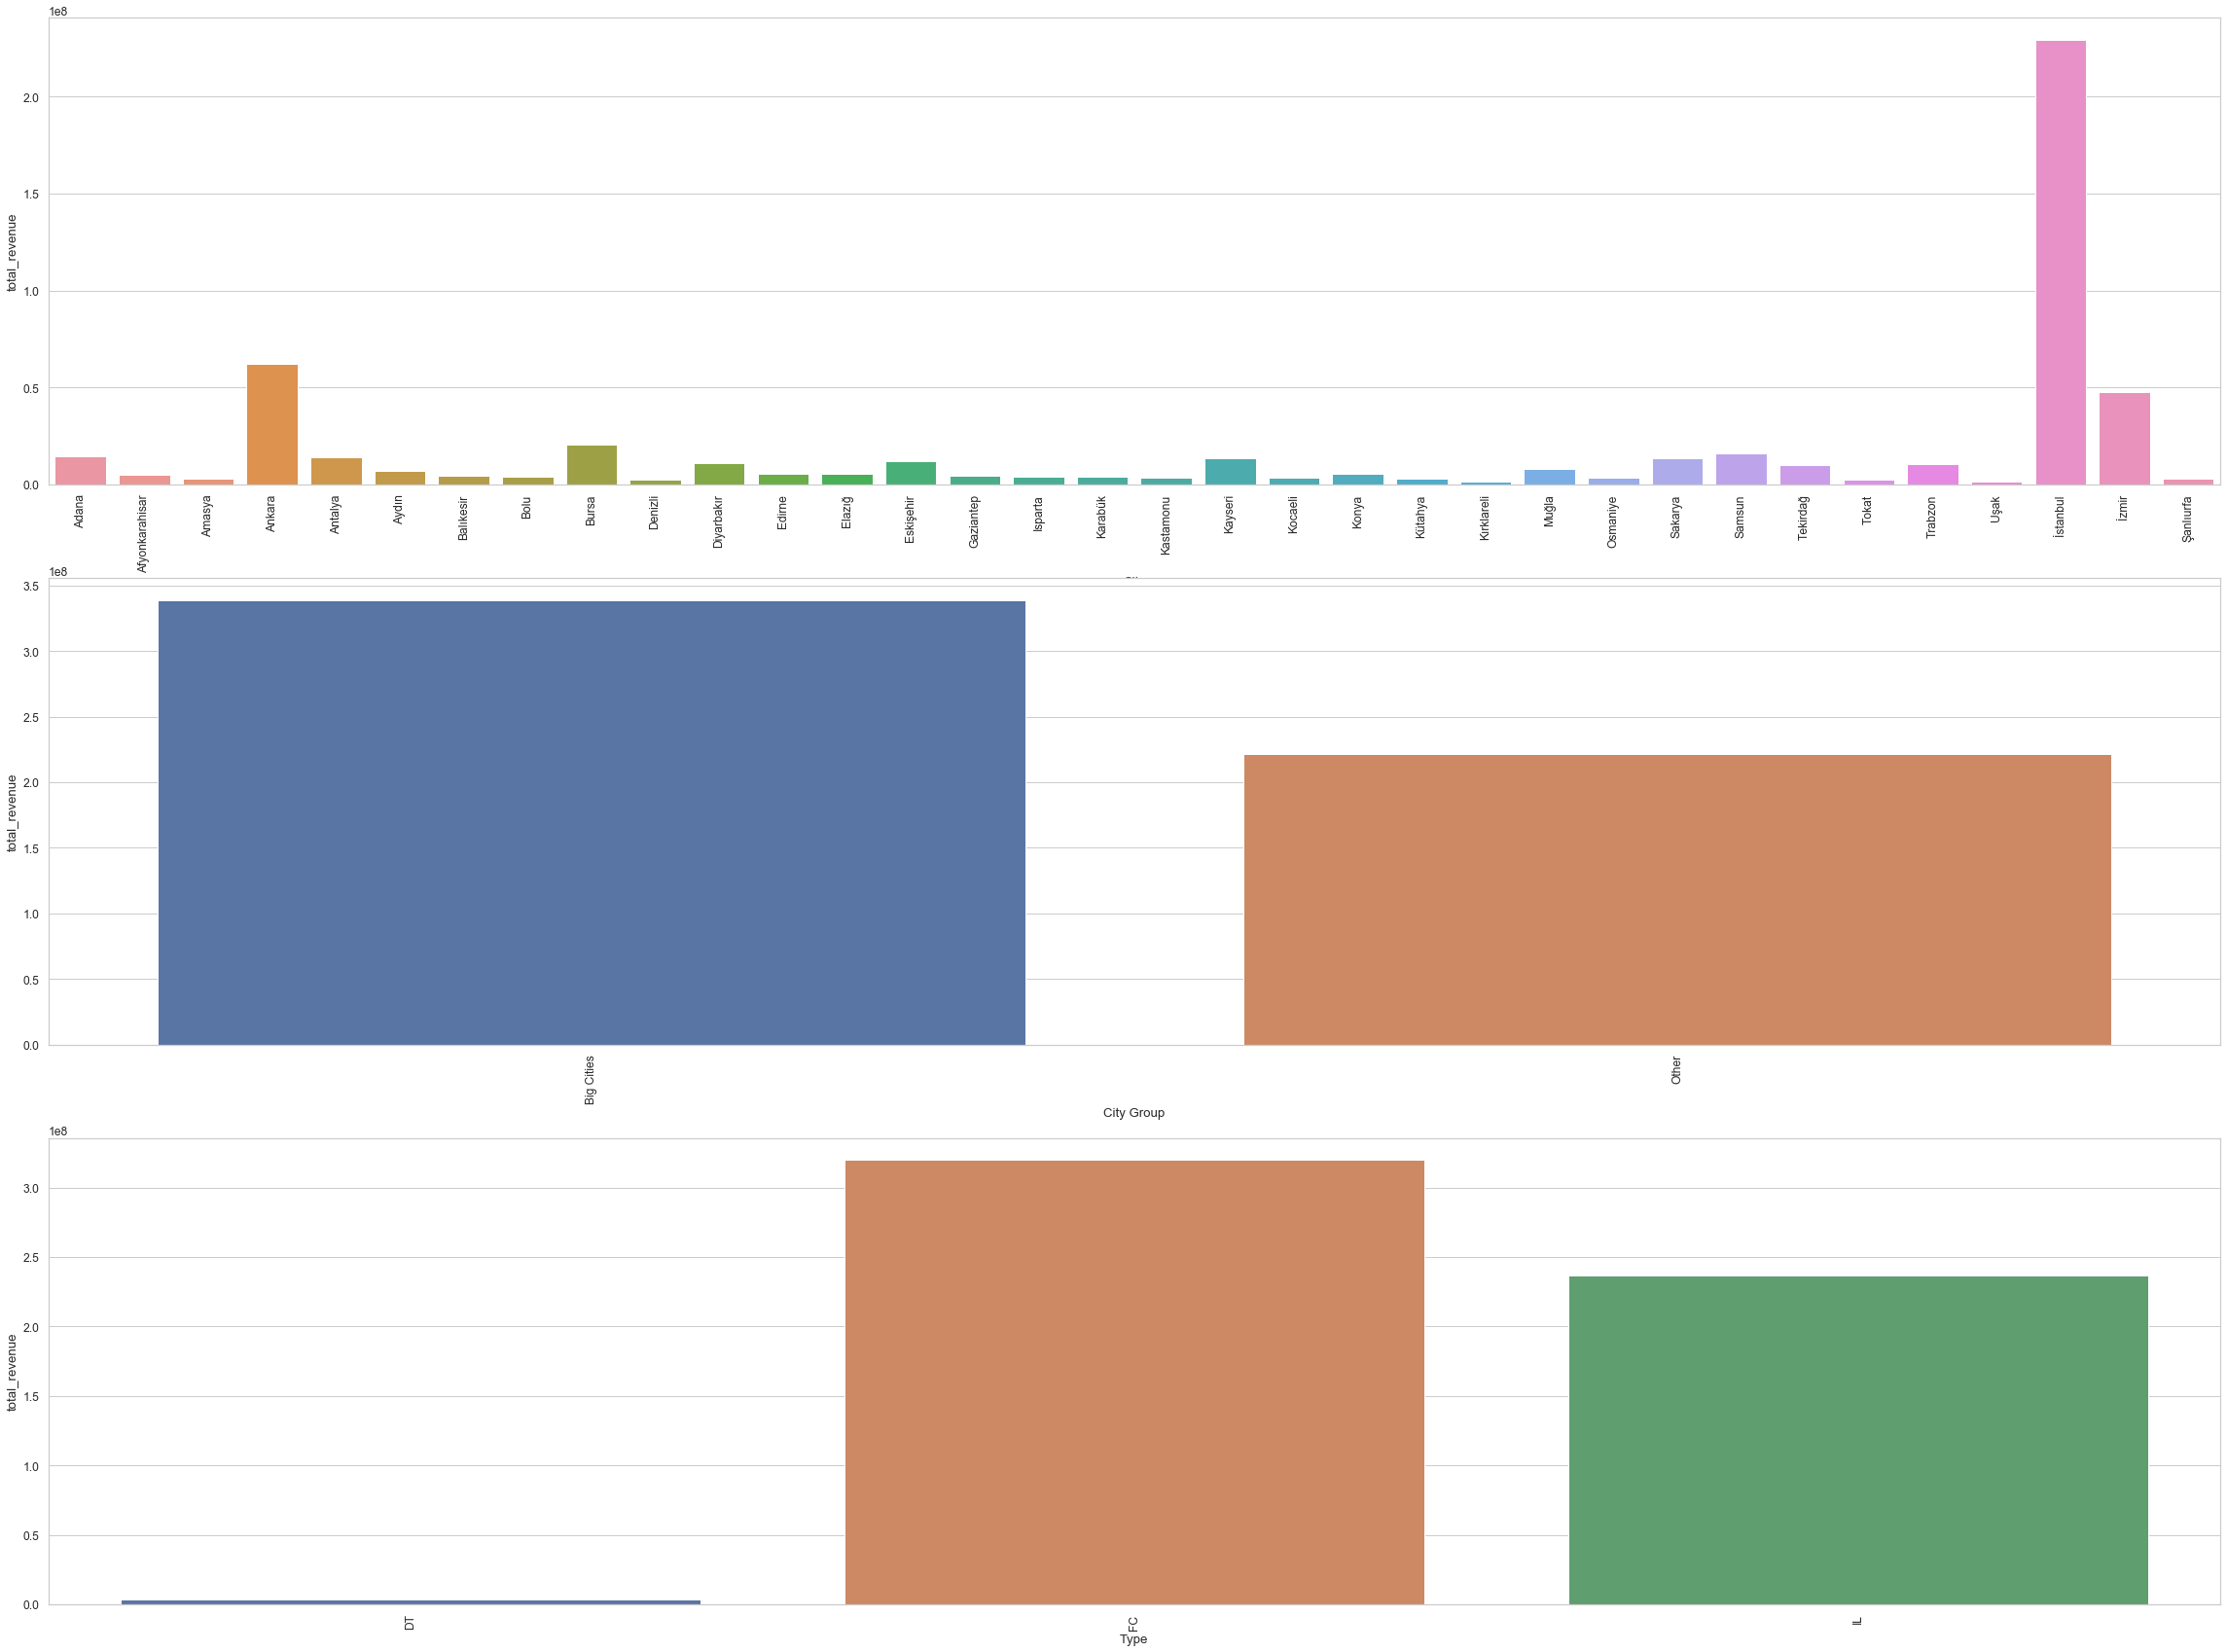

In [21]:
fig, ax = plt.subplots(3, 1, figsize=(40, 30))
for variable, subplot in zip(categorical_features, ax.flatten()):
    df_2 = train[[variable,'revenue']].groupby(variable).revenue.sum().reset_index()
    df_2.columns = [variable,'total_revenue']
    sns.barplot(x=variable, y='total_revenue', data=df_2 , ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

та відносного самого прибутку (revenue):

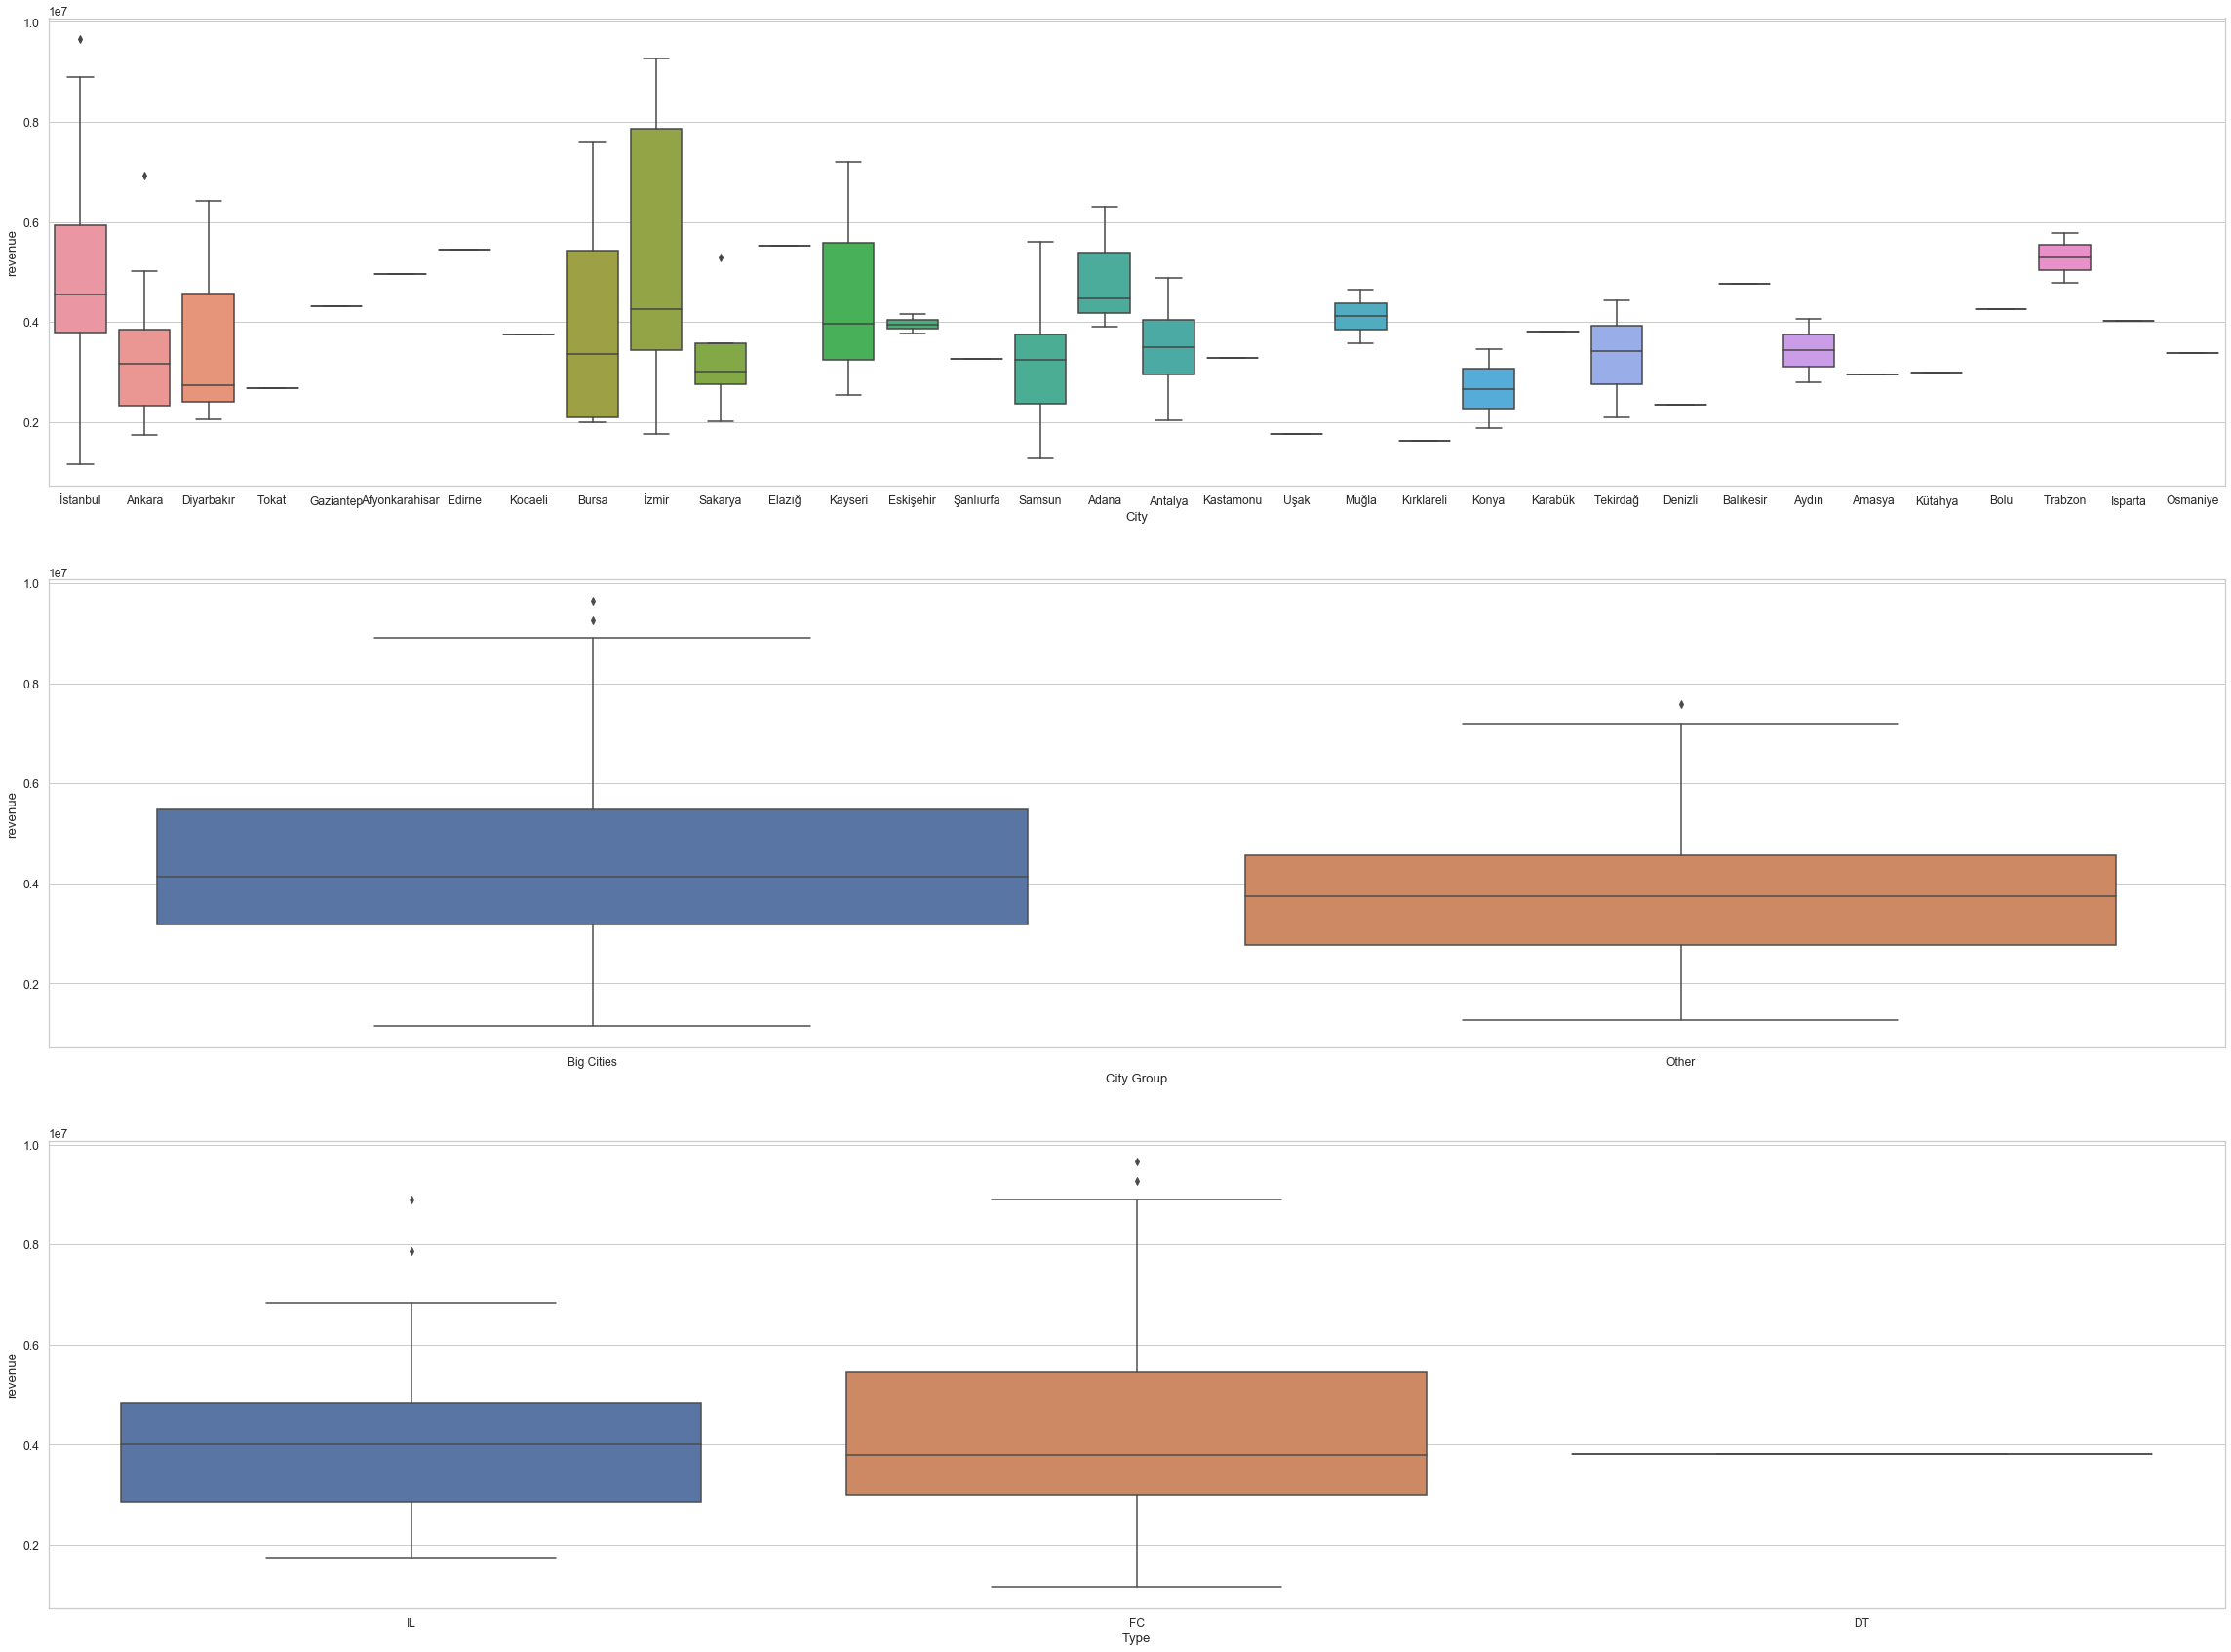

In [22]:
fig, ax = plt.subplots(3, 1, figsize=(40, 30))
for var, subplot in zip(categorical_features, ax.flatten()):
    sns.boxplot(x=var, y='revenue', data=train, ax=subplot)


На графіках видно, що:
* Стамбул є найбільш прибутковим серед інших міст
* Ресторани у великих містах прибутковіші, ніж в інших
* Найкраще функціонують ресторани типу FC i IL

Виділимо найприбутковіші міста:
* Istanbul
* Ankara
* Izmir
* Bursa
* Samsun

Побудуємо графіки прибутку відносно дати відкриття ресторанів (Open Date):

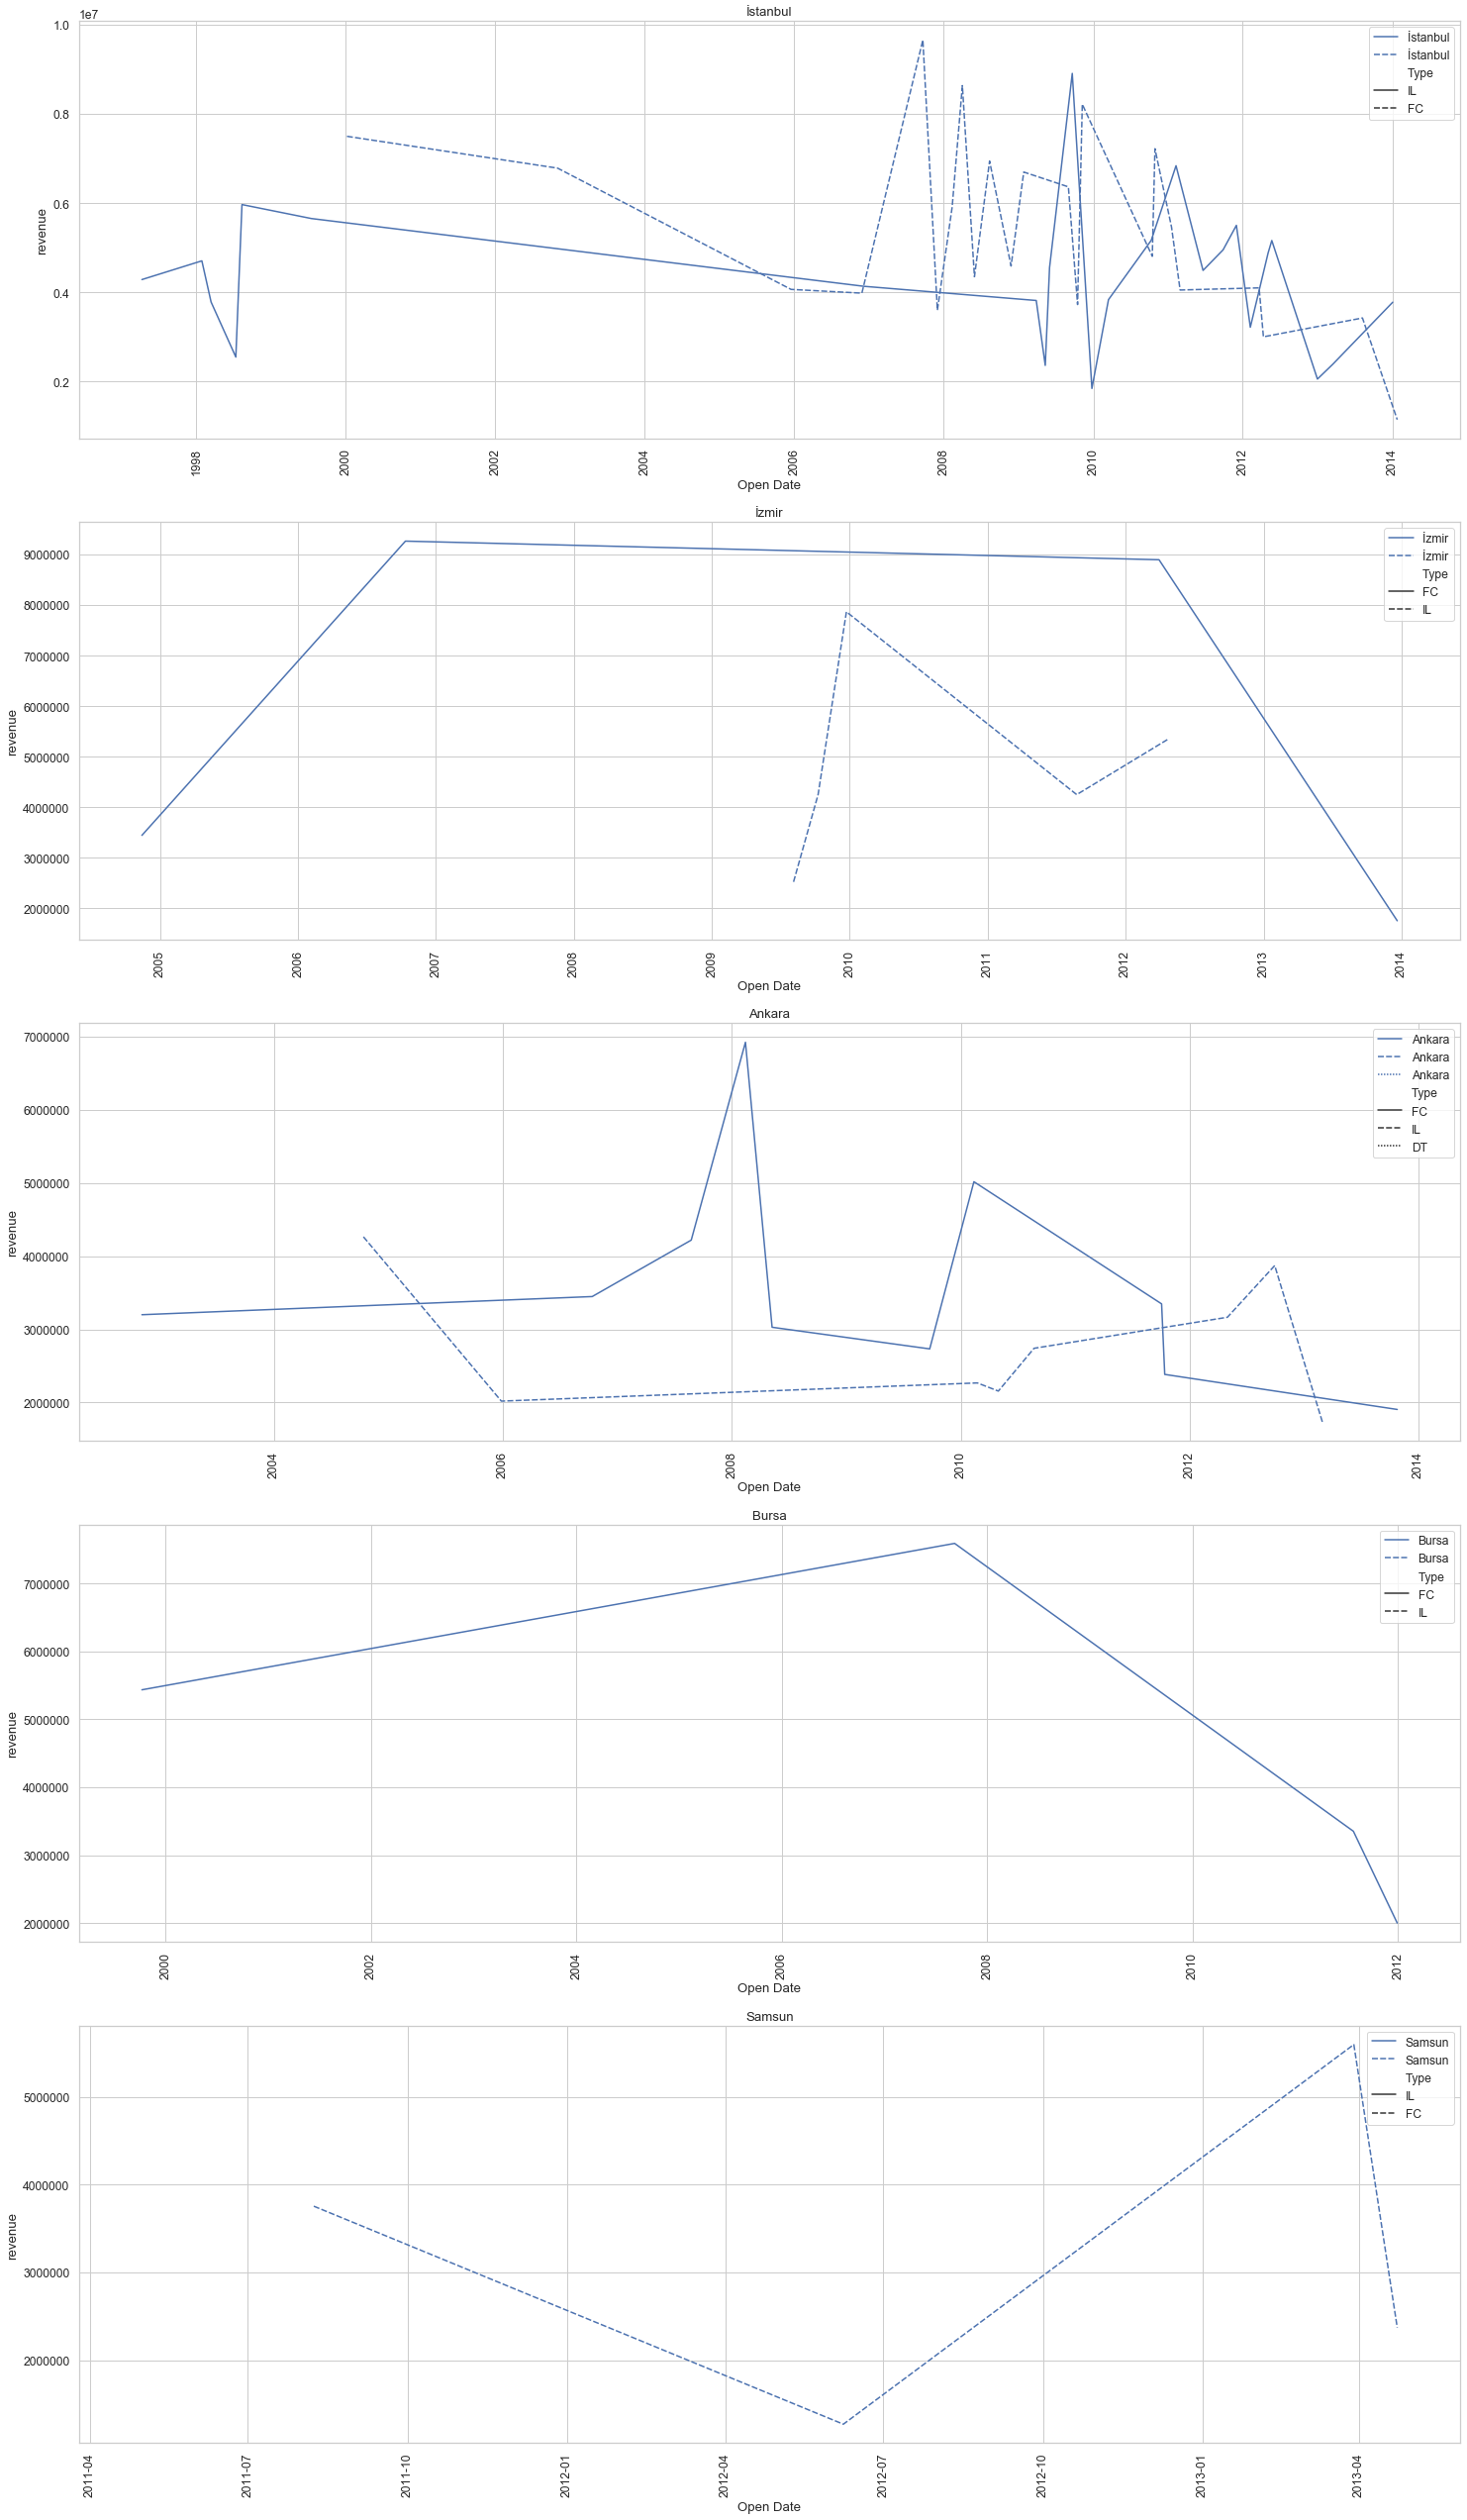

In [23]:
tem = train.copy()
cats = ['İstanbul','İzmir','Ankara','Bursa','Samsun']
fig, ax = plt.subplots(5, 1, figsize=(25, 45))
for variable, subplot in zip(cats, ax.flatten()):
    x = tem[train["City"]==variable]
    x = x.sort_values(by=['Open Date'])
    if len(x) <= 4:        
        g = sns.barplot(x="Open Date", y="revenue",hue="Type", data=x, ax=subplot)
        g.title.set_text(variable)
    else:
        g = sns.lineplot(x="Open Date", y="revenue", style = "Type",label=variable, linestyle="-", data=x, ax=subplot)
        g.title.set_text(variable)
        for label in subplot.get_xticklabels():
            label.set_rotation(90)

Можна припустити, що найкращим рішенням буде:
* відкривати новий ресторан в Стамбулі
* типу Inline (IL)
* на початку року

## 2. Feature selection and augmentation

In [24]:
num_train = train.shape[0]
num_test = test.shape[0]
print(num_train, num_test)

# combine train and test data
data = pd.concat((train.loc[:, "Id" : "P37"], test.loc[:, "Id" : "P37"]), ignore_index=True)

134 100000


Оскільки в тестових даних можуть зустрітися міста, яких не було в тренувальних, потрібно ці значення наблизити до можливих (тобто тренувальних).
Побудуємо схему відношення між Р-характеристиками і її середнім значенням для кожного міста.

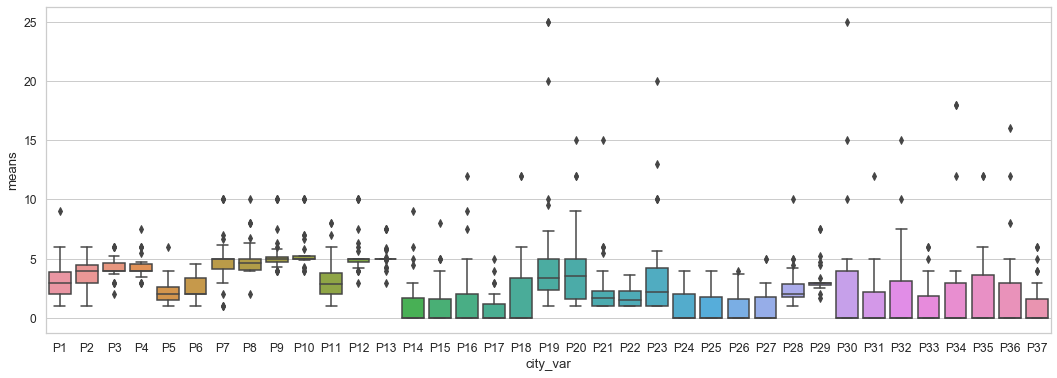

In [25]:
distinct_cities = train.loc[:, "City"].unique()

means = []
for col in train.columns[5:42]:
    temp = []
    for city in distinct_cities:
        temp.append(train.loc[train.City == city, col].mean())     
    means.append(temp)
    
city_pvars = pd.DataFrame(columns=["city_var", "means"])
for i in range(37):
    for j in range(len(distinct_cities)):
        city_pvars.loc[i+37*j] = ["P"+str(i+1), means[i][j]]

plt.rcParams['figure.figsize'] = (18.0, 6.0)
sns.boxplot(x="city_var", y="means", data=city_pvars)

На графіку бачимо, які характеристики потрібно врахувати для передбачення міста-кластера. 
З використанням пакету sklearn передбачимо, до якого міста буде відноситися нове невідоме місто. Результат запишемо в нову властивість City Cluster.

In [26]:
from sklearn import cluster
from sklearn import preprocessing
def adjust_cities(data, train, k):    
    relevant_pvars =  ["P1", "P2", "P11", "P19", "P20", "P23", "P30"]
    train = train.loc[:, relevant_pvars]      
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(train)    
    data['City Cluster'] = kmeans.predict(data.loc[:, relevant_pvars])
    del data["City"]    
    return data
def one_hot_ecoding(data,col,pref):   
    data = data.join(pd.get_dummies(data[col], prefix=pref))
    data = data.drop([col], axis=1)
    return data 

In [27]:
# Convert unknown cities in test data to clusters based on known cities using KMeans
data = adjust_cities(data, train, 20)
data = one_hot_ecoding(data,'City Group',"CG")
data = one_hot_ecoding(data,'Type',"T")

In [28]:
data.dtypes

Id                        int64
Open Date        datetime64[ns]
P1                        int64
P2                      float64
P3                      float64
P4                      float64
P5                        int64
P6                        int64
P7                        int64
P8                        int64
P9                        int64
P10                       int64
P11                       int64
P12                       int64
P13                     float64
P14                       int64
P15                       int64
P16                       int64
P17                       int64
P18                       int64
P19                       int64
P20                       int64
P21                       int64
P22                       int64
P23                       int64
P24                       int64
P25                       int64
P26                     float64
P27                     float64
P28                     float64
P29                     float64
P30     

In [29]:
# Drop nonrelevant columns
data = data.drop(['Id', 'P3', 'P4', 'P5', 'P8', 'P9',
                  'P10', 'P11', 'P12', 'P13', 'P14',
                  'P15', 'P16', 'P17', 'P18', 'P19',
                  'P20', 'P21', 'P22', 'P24', 'P25',
                  'P26', 'P27', 'P29','P30', 'P31', 
                  'P32', 'P33', 'P34', 'P35', 'P36', 
                  'P37', 'T_MB'], axis=1)

In [30]:
import time
from datetime import datetime as dt

df = data.copy()

# Split the date column into three columns 
df['Open Date Year']  = df['Open Date'].dt.year
df['Open Date Month']  = df['Open Date'].dt.month
df['Open Date Day']  = df['Open Date'].dt.day    
 
# Drop Open Date column
df = df.drop(['Open Date'], axis=1)

In [31]:
#split into train and test data
train_processed = df[:num_train]
test_processed = df[num_train:]
train_processed["revenue"] = train["revenue"].values
train = train_processed
test = test_processed

print("Train :",train.shape)
print("Test:",test.shape)

Train : (134, 16)
Test: (100000, 15)


c:\users\vika\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Отже, дані нормовані і готові до обробки навчальним алгоритмом.

## 3. Algorithm selection
### Manual realization


In [32]:
def prepare_X(X):
    m = X.shape[0]
    ones = np.ones((m, 1))
    X_new = np.array(X[:])
    X_new = np.column_stack((ones, X_new))
    return X_new

In [33]:
def plot_data(X_train, X_test, y_train, y_test):
    plt.scatter(X_train, y_train, marker='^', c='green')
    plt.scatter(X_test, y_test, marker='o', c='red')
    plt.show()

In [34]:
def normalize(X):
    mean = np.mean(X)
    std = np.std(X)
    X_new = (X - mean) / std
    return X_new, mean, std

In [35]:
X_train = train.iloc[:, 1:]
y_train = train.iloc[:, 15:].values

X_test = test

X_train_norm, mean, std = normalize(X_train)
X_train = prepare_X(X_train_norm)

theta = np.zeros([len(train.columns), 1])

In [36]:
X_train.shape, y_train.shape, X_test.shape, theta.shape

((134, 16), (134, 1), (100000, 15), (16, 1))

Формуємо гіпотезу:

In [37]:
def hypothesis(X, theta):
    h_theta = np.dot(X, theta)
    return h_theta

Штрафна функція J(Θ):

In [38]:
def cost_function(X, y, theta):
    m = X.shape[0]
    if m == 0:
        return None
    J = np.sum((hypothesis(X, theta) - y)**2)/(2*m)
    return J

Функція похідних штрафної функції:

In [39]:
def derivative(X, y, theta):
    m = X.shape[0]
    d_theta = np.dot(np.transpose(X), hypothesis(X, theta) - y) / m
    return d_theta

Параметри моделі (к-сть ітерацій та швидкість навчання):

In [40]:
iterations = 500
alpha = 0.01

Градієнтний спуск (gradient descent) для обчислення вектора Θ:

In [41]:
def gradientdescent(X, y, theta, iterations, alpha):
    m = X.shape[0]
    J_history = []
    J = cost_function(X, y, theta)
    J_history.append(J)
    for i in range(iterations - 1):
        delta = derivative(X, y, theta)
        theta = theta - alpha*delta
        J = cost_function(X, y, theta)
        J_history.append(J)
    return theta, J_history

In [42]:
# Compute and display Θ
Theta, J_history = gradientdescent(X_train, y_train, theta, iterations, alpha)
Theta

array([[ 4.15368678e+06],
       [ 1.79851084e+04],
       [-2.38927289e+04],
       [-2.04152772e+04],
       [ 2.45851417e+04],
       [ 8.57666527e+03],
       [ 4.58101663e+03],
       [ 5.46896338e+03],
       [-5.46896338e+03],
       [-4.43952007e+03],
       [ 6.57932112e+03],
       [-5.82079193e+03],
       [-1.75302494e+04],
       [-3.55437919e+03],
       [ 9.74837185e+03],
       [ 1.75937708e+06]])

In [43]:
# Compute and display cost
J = cost_function(X_train, y_train, Theta)
J

1227014678.0324147

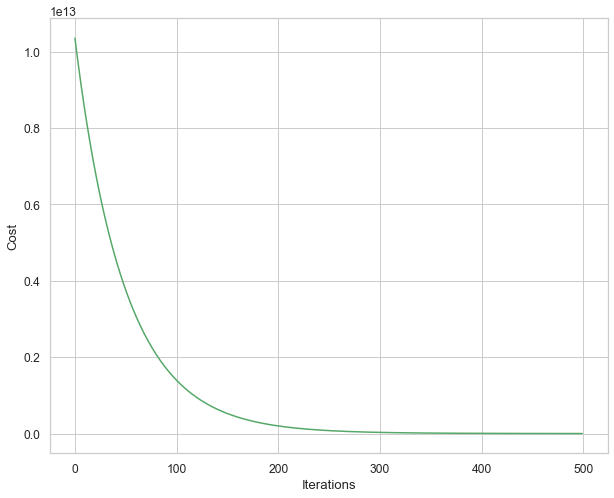

In [44]:
# Plot Iterations vs. Cost figure
fig_2, ax = plt.subplots(figsize=(10, 8))
ax.plot(np.arange(iterations), J_history, 'g')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')

plt.show()

## Result evaluation

Застосуємо на тренувальних даних:

In [45]:
y_train_pred = hypothesis(X_train, Theta)
rel_diff = np.abs(np.divide(y_train - y_train_pred, y_train))* 100
print(' y_actual\ty_pred\t err(%)')
for i in range(134):
    print(y_train[i], y_train_pred[i].round(2), rel_diff[i].round(2))

 y_actual	y_pred	 err(%)
[5653753.] [5669661.95] [0.28]
[6923131.] [6893946.71] [0.42]
[2055379.] [1998762.92] [2.75]
[2675511.] [2620395.75] [2.06]
[4316715.] [4248362.72] [1.58]
[5017319.] [4927118.97] [1.8]
[5166635.] [5051853.37] [2.22]
[4491607.] [4452732.41] [0.87]
[4952497.] [4889068.45] [1.28]
[5444227.] [5351638.83] [1.7]
[3745135.] [3782987.59] [1.01]
[5161370.] [5084615.75] [1.49]
[1734634.] [1729335.81] [0.31]
[4807746.] [4786698.09] [0.44]
[1999097.] [1986917.67] [0.61]
[3218918.] [3142230.76] [2.38]
[8213524.] [8097811.84] [1.41]
[5337526.] [5302649.61] [0.65]
[2021934.] [1992447.73] [1.46]
[5525735.] [5464529.95] [1.11]
[1149870.] [1199987.69] [4.36]
[3956086.] [3925381.41] [0.78]
[2999068.] [2973140.89] [0.86]
[8904084.] [8808355.24] [1.08]
[3778621.] [3744900.89] [0.89]
[2267425.] [2295679.25] [1.25]
[5435276.] [5462118.14] [0.49]
[4705945.] [4758360.12] [1.11]
[3447890.] [3463383.8] [0.45]
[3008199.] [2960790.28] [1.58]
[2058644.] [2062306.63] [0.18]
[3261924.] [32476

Як бачимо, похибка кожного з прикладів є дуже незначною.
Загальна похибка на тренувальному датасеті:

In [46]:
from sklearn.metrics import r2_score
r2_score(y_train, y_train_pred)

0.9992365456782228

Оскільки в тестовому датасеті немає колонки revenue, то ми лише побудуємо для нього передбачення:

In [47]:
X_test_norm, mean, std = normalize(X_test)
X_test = prepare_X(X_test_norm)

y_test_pred = hypothesis(X_test, Theta)
y_test_pred

array([[5605416.69713817],
       [4797138.44897643],
       [7205345.63787556],
       ...,
       [6977275.81313421],
       [3735601.22558393],
       [2261799.33966605]])

### Sklearn-package


In [48]:
lr = linear_model.LinearRegression()
lr.fit(X_train,y_train)

pred = lr.predict(X_train)
rel_diff = np.abs(np.divide(y_train - pred, y_train))* 100
print(' y_actual\ty_pred\t err(%)')
for i in range(134):
    print(y_train[i], pred[i].round(2), rel_diff[i].round(2))

 y_actual	y_pred	 err(%)
[5653753.] [5653753.] [0.]
[6923131.] [6923131.] [0.]
[2055379.] [2055379.] [0.]
[2675511.] [2675511.] [0.]
[4316715.] [4316715.] [0.]
[5017319.] [5017319.] [0.]
[5166635.] [5166635.] [0.]
[4491607.] [4491607.] [0.]
[4952497.] [4952497.] [0.]
[5444227.] [5444227.] [0.]
[3745135.] [3745135.] [0.]
[5161370.] [5161370.] [0.]
[1734634.] [1734634.] [0.]
[4807746.] [4807746.] [0.]
[1999097.] [1999097.] [0.]
[3218918.] [3218918.] [0.]
[8213524.] [8213524.] [0.]
[5337526.] [5337526.] [0.]
[2021934.] [2021934.] [0.]
[5525735.] [5525735.] [0.]
[1149870.] [1149870.] [0.]
[3956086.] [3956086.] [0.]
[2999068.] [2999068.] [0.]
[8904084.] [8904084.] [0.]
[3778621.] [3778621.] [0.]
[2267425.] [2267425.] [0.]
[5435276.] [5435276.] [0.]
[4705945.] [4705945.] [0.]
[3447890.] [3447890.] [0.]
[3008199.] [3008199.] [0.]
[2058644.] [2058644.] [0.]
[3261924.] [3261924.] [0.]
[2371202.] [2371202.] [0.]
[4100886.] [4100886.] [0.]
[3903884.] [3903884.] [0.]
[3028267.] [3028267.] [0.]
[27

In [49]:
r2_score(y_train, pred)

1.0

Алгоритм з бібліотеки sklearn повністю відтворює тренувальні дані. Похибка відсутня.

In [50]:
# Root Mean Squared Error
rmse = np.sqrt(((y_train_pred - y_train) ** 2).mean())

# Mean Squared Error
mse = ((y_train_pred - y_train) ** 2).mean()

# Mean Absolute Error
mae = (abs(y_train_pred - y_train)).mean()

print('RMSE: ', rmse)
print('MSE: ', mse)
print('MAE: ', mae)

RMSE:  49538.16060437478
MSE:  2454029356.0648293
MAE:  39224.75111874817
